## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import time
from tqdm import tqdm_notebook
import wget

In [2]:
import gcsfs

In [3]:
import glob

In [4]:
import pyarrow

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [8]:
import seaborn as sns

In [6]:
from dask.distributed import Client, progress, LocalCluster
import dask

In [7]:
import dask.dataframe as dd

In [108]:
from dask.diagnostics import ProgressBar

## Gathering data to use as exogenous variables in time series models

In [11]:
cluster = LocalCluster(processes=True, n_workers=4)
client = Client(cluster)

In [13]:
dask.__version__

'2.8.0'

In [14]:
gcs = gcsfs.GCSFileSystem()

In [15]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/*.parquet/')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-11.parquet',
 'gcs://ny

In [16]:
%time data_hr_2018 = dd.read_parquet(filelist_gcs)

CPU times: user 176 ms, sys: 12 ms, total: 188 ms
Wall time: 889 ms


### Date features

Creating variables for weekends, day of the week, month and time past since beginning of 2018

In [29]:
lst_dates = data_hr_2018.index.compute()

In [37]:
lst_days = lst_dates.day_name()

In [40]:
lst_month = lst_dates.month_name()

In [43]:
dates_table = pd.DataFrame({'date':lst_dates, 'weekday':lst_days, 'month':lst_month})

In [54]:
dates_table['weekend'] = dates_table.date.apply(lambda x : 0 if int(x.weekday()) <5 else 1)

In [63]:
dates_table['since_2018'] = dates_table.date.apply(lambda x: (pd.to_datetime(x)-pd.to_datetime('2018-01-01')).days)

Saving date features to file

In [66]:
dates_table.to_csv('gcs://nyc-taxi-data-2018-2019/date_features_2018.csv', index = False)

### Weather data

Weather data was gathered from NOAA website. It consists of historical daily weather information from JFK weather station. Full table has lots of different weather parameters. I decided to focus on info about wind, rain, temperature, snow and fog.

In [18]:
weather_df = dd.read_csv('gcs://nyc-taxi-data-2018-2019/weather_JFK.csv', parse_dates = ['DATE'])

In [19]:
weather_df.head()

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,...,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",2015-12-01,10.96,NaN,0.29,0.0,0.0,48.0,53,...,21.9,25.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",2015-12-02,4.47,NaN,0.12,0.0,0.0,50.0,57,...,17.0,23.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",2015-12-03,16.11,NaN,0.00,0.0,0.0,52.0,56,...,25.9,33.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",2015-12-04,10.51,NaN,0.00,0.0,0.0,47.0,53,...,18.1,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",2015-12-05,5.37,NaN,0.00,0.0,0.0,45.0,53,...,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
weather_df = weather_df.set_index('DATE').drop(['STATION', 'NAME'], axis = 1)

In [66]:
weather_df.isna().sum().compute()

AWND       1
PGTM    1445
PRCP       0
SNOW       0
SNWD       0
TAVG       1
TMAX       0
TMIN       0
WDF2       1
WDF5      14
WSF2       1
WSF5      14
WT01     862
WT02    1331
WT03    1334
WT04    1426
WT05    1445
WT06    1438
WT08    1363
WT09    1440
dtype: int64

In [70]:
weather_df.compute().shape

(1446, 20)

In [71]:
weather_df = weather_df.drop(['PGTM', 'WDF5', 'WSF5', 'WT02','WT03','WT04', 'WT05', 'WT06', 'WT08', 'WT09'], axis = 1)

No information about the fog filling with 0

In [73]:
weather_df.WT01 = weather_df.WT01.fillna(0)

In [78]:
weather_df.describe().compute()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WSF2,WT01
count,1445.000000,1446.00000,1446.000000,1446.000000,1445.000000,1446.000000,1446.000000,1445.00000,1445.000000,1446.000000
mean,11.459896,0.12713,0.084716,0.221577,55.784775,63.060166,48.838174,211.99308,22.090173,0.403873
std,4.386223,0.31803,0.963461,1.522138,16.438588,17.254532,16.498173,98.15987,6.818516,0.490842
min,2.010000,0.00000,0.000000,0.000000,8.000000,14.000000,1.000000,10.00000,8.100000,0.000000
25%,8.280000,0.00000,0.000000,0.000000,43.000000,49.000000,36.000000,150.00000,17.000000,0.000000
50%,10.740000,0.00000,0.000000,0.000000,55.000000,63.000000,49.000000,200.00000,21.000000,0.000000
75%,13.650000,0.06000,0.000000,0.000000,71.000000,78.000000,64.000000,310.00000,25.900000,1.000000
max,29.970000,2.90000,30.300000,28.000000,89.000000,99.000000,82.000000,360.00000,51.000000,1.000000


In [79]:
weather_df = weather_df.fillna(method='ffill')

Saving weather features to file

In [85]:
weather_df.compute().to_csv('gcs://nyc-taxi-data-2018-2019/weather_filled.csv')

In [24]:
weather_df = weather_df.set_index('DATE')

In [69]:
weather_df_2018 = weather_df['2018'].compute()

In [83]:
dates_table.columns = ['DATE', 'weekday', 'month', 'weekend', 'since_2018']

Join date and weather features on date, fill whole day with same weather information

In [91]:
joined_2018 = dates_table.join(weather_df_2018, on='DATE').fillna(method = 'ffill')

In [92]:
joined_2018.to_csv('gcs://nyc-taxi-data-2018-2019/date_weather_features_2018.csv', index = False)

### City Bike data

Downloading files with City Bike data for whole 2018

In [93]:
url = 'https://s3.amazonaws.com/tripdata/201801-citibike-tripdata.csv.zip'

In [97]:
start_time = time.time()

for i in tqdm_notebook(['01','02','03','04', '05', '06', '07', '08', '09', '10', '11', '12']):
    url = f'https://s3.amazonaws.com/tripdata/2018{i}-citibike-tripdata.csv.zip'
    df = pd.read_csv(url)
    df.to_csv(f'gs://nyc-taxi-data-2018-2019/bike_2018/citibike_2018-{i}.csv')

print("--- %s seconds ---" % (time.time() - start_time))


--- 926.3888111114502 seconds ---


Convert to parquet files

In [106]:
def conv_to_parq(i):
    df = dd.read_csv(f'gs://nyc-taxi-data-2018-2019/bike_2018/citibike_2018-{i}.csv', parse_dates = ['starttime', 'stoptime'])
    df.to_parquet(f'gcs://nyc-taxi-data-2018-2019/bike_2018/citibike_2018-{i}.parquet', engine = 'pyarrow')

In [107]:
y = []
for x in tqdm_notebook(['01','02','03','04', '05', '06', '07', '08', '09', '10', '11', '12']):
    y.append(dask.delayed(conv_to_parq)(x))
progress(dask.compute(y))

VBox()

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7faa688d96a8>, <Task finished coro=<MultiProgressBar.listen() done, defined at /opt/conda/anaconda/lib/python3.6/site-packages/distributed/diagnostics/progressbar.py:238> exception=AttributeError("'MultiProgressWidget' object has no attribute 'elapsed_time'",)>)
Traceback (most recent call last):
  File "/opt/conda/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/opt/conda/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 780, in _discard_future_result
    future.result()
  File "/opt/conda/anaconda/lib/python3.6/site-packages/distributed/diagnostics/progressbar.py", line 282, in listen
    self._draw_stop(**response)
  File "/opt/conda/anaconda/lib/python3.6/sit

Extract needed information from City Bike dataset first for January 2018

In [111]:
with ProgressBar():
    df = dd.read_parquet(f'gcs://nyc-taxi-data-2018-2019/bike_2018/citibike_2018-01.parquet', parse_dates = ['starttime', 'stoptime'], columns = ['starttime', 'stoptime','tripduration', 'start station id'])
    df = df.set_index('starttime')
    rng = f'2018-01'
    df = df[rng:rng]
    
    # calculate hourly bike demand in whole NYC area
    demand_hr = df['tripduration'].resample('h').count()
    demand_hr = demand_hr.rename("demand")
    
    # calculate hourly average bike trip distance
    duration_avg = df['tripduration'].resample('h').mean()
    
    # merge dataframes
    df_2 = dd.concat([demand_hr, duration_avg], axis=1)
    df_2 = df_2.compute()
    
    #save to parquet
    df_2.to_parquet(f'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-01.parquet', engine = 'pyarrow')

Repeat for all months in 2018

In [115]:
def create_hr_parq(month):
    df = dd.read_parquet(f'gcs://nyc-taxi-data-2018-2019/bike_2018/citibike_2018-{month}.parquet', parse_dates = ['starttime', 'stoptime'], columns = ['starttime', 'stoptime','tripduration', 'start station id'])
    df = df.set_index('starttime')
    rng = f'2018-{month}'
    df = df[rng:rng]
    demand_hr = df['tripduration'].resample('h').count()
    demand_hr = demand_hr.rename("demand")
    duration_avg = df['tripduration'].resample('h').mean()
    df_2 = dd.concat([demand_hr, duration_avg], axis=1)
    df_2 = df_2.compute()
    df_2.to_parquet(f'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-{month}.parquet', engine = 'pyarrow')

In [116]:
for month in tqdm_notebook(['02','03','04', '05', '06', '07', '08', '09', '10', '11', '12']):
    create_hr_parq(month)

#### City Bike data exploration

Average trip distance

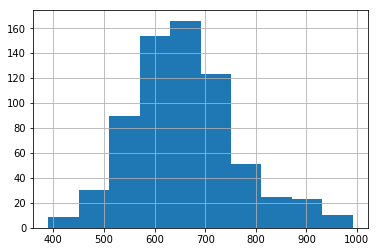

In [126]:
df_2[df_2.tripduration < 1000].tripduration.hist()

Average hourly and weekday bike demand

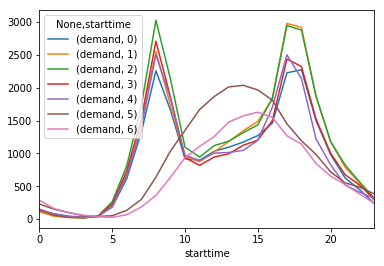

In [131]:
df_2[['demand']].groupby([df_2.index.hour,df_2.index.weekday]).mean().unstack().plot()

Average trip duration time

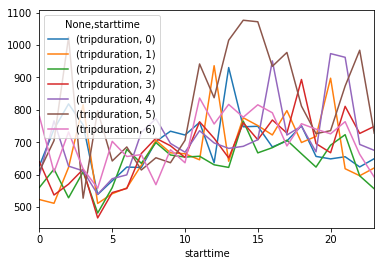

In [136]:
df_2[df_2.tripduration < 2000][['tripduration']].groupby([df_2[df_2.tripduration < 2000].index.hour,df_2[df_2.tripduration < 2000].index.weekday]).mean().unstack().plot()

#### Combine all months to one file

In [137]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/bike_2018_hr/*.parquet/')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-11.parquet',
 'gcs://nyc-taxi-data-2018-2019/bike_2018_hr/citibike_2018-12.parquet']

In [138]:
%time bike_hr_2018 = dd.read_parquet(filelist_gcs)

CPU times: user 144 ms, sys: 8 ms, total: 152 ms
Wall time: 984 ms


In [153]:
bike_hr_2018.compute().to_csv('gcs://nyc-taxi-data-2018-2019/bike_hr_features_2018.csv', index = False)

In [158]:
bike_hr_2018.index = bike_hr_2018.index.rename('DATE')

In [162]:
bike_hr_2018.reset_index()

,DATE,demand,tripduration
npartitions=12,,,
,datetime64[ns],int64,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


#### Join exogenous varaible table on date

In [164]:
joined_bike_2018 = joined_2018.join(bike_hr_2018.compute(), on='DATE')

In [173]:
joined_bike_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
DATE            8760 non-null datetime64[ns]
weekday         8760 non-null object
month           8760 non-null object
weekend         8760 non-null int64
since_2018      8760 non-null int64
AWND            8760 non-null float64
PRCP            8760 non-null float64
SNOW            8760 non-null float64
SNWD            8760 non-null float64
TAVG            8760 non-null float64
TMAX            8760 non-null float64
TMIN            8760 non-null float64
WDF2            8760 non-null float64
WSF2            8760 non-null float64
WT01            8760 non-null float64
demand          8760 non-null int64
tripduration    8743 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(3), object(2)
memory usage: 1.1+ MB


In [178]:
joined_bike_2018 = joined_bike_2018.fillna(0)

In [179]:
joined_bike_2018.head()

,DATE,weekday,month,weekend,since_2018,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WSF2,WT01,demand,tripduration
0,2018-01-01 00:00:00,Monday,January,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,119,704.831933
1,2018-01-01 01:00:00,Monday,January,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,168,1298.660714
2,2018-01-01 02:00:00,Monday,January,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,98,539.020408
3,2018-01-01 03:00:00,Monday,January,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,72,647.138889
4,2018-01-01 04:00:00,Monday,January,0,0,17.67,0.0,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,34,502.205882


In [180]:
joined_bike_2018.to_csv('gcs://nyc-taxi-data-2018-2019/date_weather_bike_hr_features_2018.csv', index = False)